# Linear regression, lambda KAN sensitivity to input visualization

In [31]:
import os
import sys

import torch
import torchmetrics
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

from collections import defaultdict
from torch.nn.modules.pooling import MaxPool2d
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, utils
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from IPython.display import clear_output

import torch
import torchmetrics
import lightning as L
import torch.nn as nn
import matplotlib.pyplot as plt

from torchmetrics import MetricCollection
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassAUROC,
)
from lightning.pytorch.callbacks import ModelCheckpoint
from tbparse import SummaryReader

from kan import KANLayer
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('__file__'))))
from models import show_sensitivity
import random

Shape with bias: (784, 10)


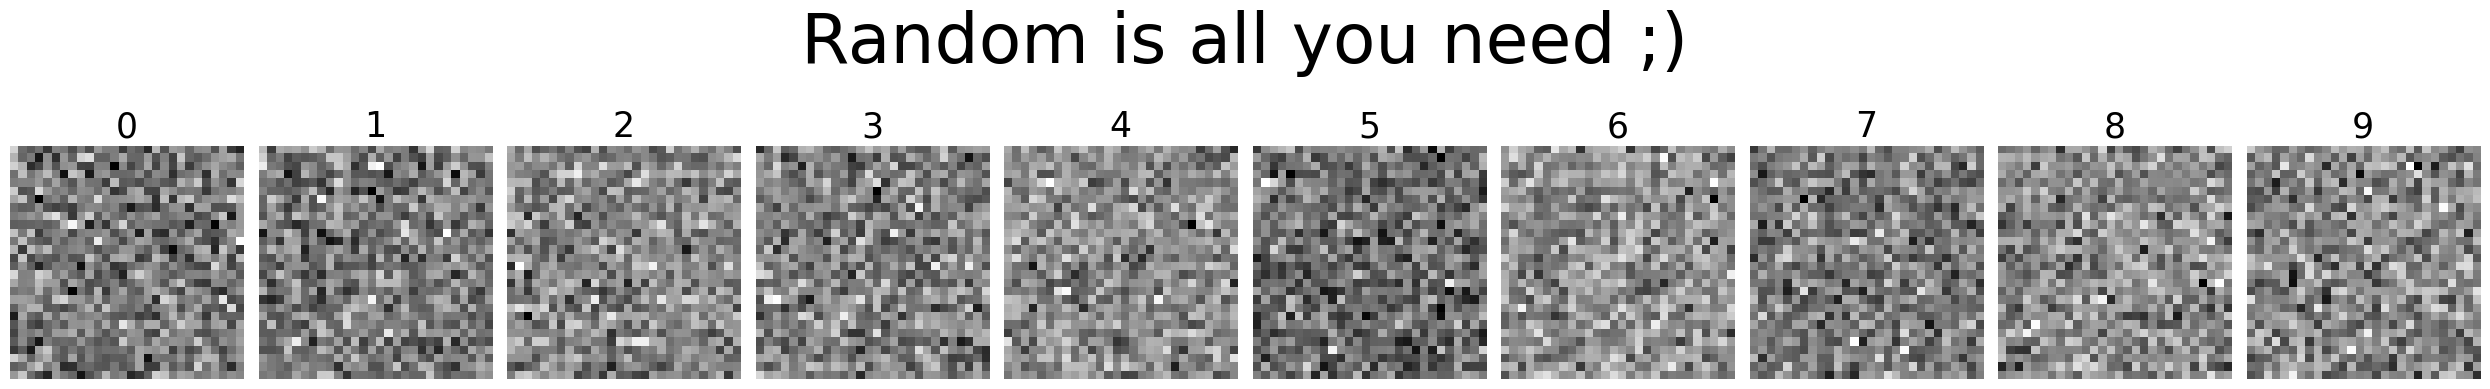

In [32]:
W = torch.randn(28*28, 10).numpy()

show_sensitivity(W, title='Random is all you need ;)')

### Load [MNIST](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST):

In [33]:
batch_size = 256

transform = v2.Compose(
    [
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

mnist = datasets.MNIST(root="./", train=True, download=True, transform=transform)

(train_set, val_set,) = torch.utils.data.random_split(
    mnist, [50000, 10000], generator=torch.Generator().manual_seed(42)
)
test_set = datasets.MNIST(root="./", train=False, download=True, transform=transform)

val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, persistent_workers=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2, persistent_workers=True)

### Create LightningModule class

In [34]:
class LModel(L.LightningModule):
    def __init__(self, model, lr=0.001):
        super().__init__()
        self.save_hyperparameters(logger=False)

        # for optimizer and shaduler
        self.lr = lr

        # model
        self.model = model
        self.criterion = nn.CrossEntropyLoss()

        # metrics
        self.metrics = MetricCollection([
            MulticlassAccuracy(num_classes=10,),
            #MulticlassF1Score(num_classes=10,),
            #MulticlassAUROC(num_classes=10,)
        ])
        self.train_metrics = self.metrics.clone(postfix='/train')
        self.val_metrics = self.metrics.clone(postfix='/val')

    def configure_optimizers(self):
        # set optimizer
        optimizer = torch.optim.Adam(
            self.model.parameters(),
            lr=self.lr,
        )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",  # or 'step'
                "monitor": "loss" # only for self.log
            },
        }

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.train_metrics.update(out, y)
        self.log("loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        self.val_metrics.update(out, y)

    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute())
        self.train_metrics.reset()

        val_metrics = self.val_metrics.compute()
        self.log_dict(val_metrics)
        self.val_metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        self.metrics.update(out, y)

    def on_test_epoch_end(self):
        self.log_dict(self.metrics.compute())
        self.metrics.reset()

In [19]:
trainer = L.Trainer(logger=L.pytorch.loggers.TensorBoardLogger(save_dir=f"./logs/{type(model).__name__}/"),
)

NameError: name 'model' is not defined

## Linear regression

### Calculate metrics on test dataset

In [35]:
log_path='logs/MnistLR/lightning_logs/version_0/'
ckpt_path = f"{log_path}/checkpoints/last.ckpt"

pl_model = LModel.load_from_checkpoint(ckpt_path)

# Load the best checkpoint automatically (lightning tracks this for you)
LR_acc = trainer.test(
    model=pl_model, dataloaders=test_loader, verbose=True)[0]['MulticlassAccuracy']
pl_model

c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


Testing DataLoader 0: 100%|██████████| 40/40 [00:01<00:00, 38.31it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.9249136447906494     │
└───────────────────────────┴───────────────────────────┘

LModel(
  (model): MnistLR(
    (layers): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=784, out_features=10, bias=True)
    )
  )
  (criterion): CrossEntropyLoss()
  (metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
  )
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    postfix=/train
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    postfix=/val
  )
)

### Plot sensitivity map

Shape with bias: (784, 10)


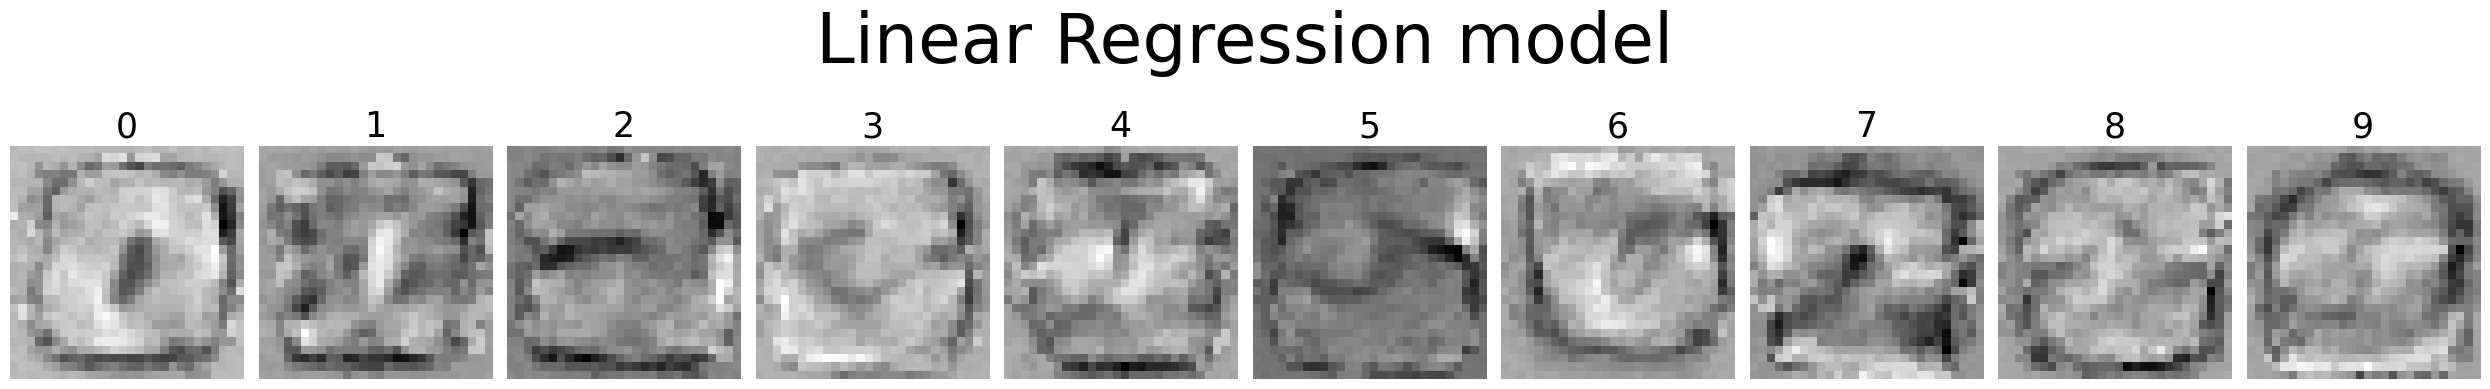

In [36]:
LR_layer = pl_model.model.layers[1].state_dict()
W = LR_layer['weight'].permute(1,0).detach().clone().numpy()

show_sensitivity(W, title='Linear Regression model')

## lambda KAN

### Calculate metrics on test dataset

In [37]:
log_path='logs/Mnist_lmdSplineKAN/lightning_logs/version_0/'
ckpt_path = f"{log_path}/checkpoints/last.ckpt"

pl_model = LModel.load_from_checkpoint(ckpt_path)
# Load the best checkpoint automatically (lightning tracks this for you)
lmdKAN_acc = trainer.test(
    model=pl_model, dataloaders=test_loader, verbose=True)[0]['MulticlassAccuracy']
pl_model

Testing DataLoader 0: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.8932843208312988     │
└───────────────────────────┴───────────────────────────┘

LModel(
  (model): Mnist_lmdSplineKAN(
    (l_layers): ModuleList(
      (0-9): 10 x Sequential(
        (0): Flatten(start_dim=1, end_dim=-1)
        (1): lmdSplineKANLayer(
          (base_fun): SiLU()
        )
        (2): Tanh()
        (3): Linear(in_features=64, out_features=32, bias=True)
        (4): Tanh()
        (5): Linear(in_features=32, out_features=1, bias=True)
      )
    )
  )
  (criterion): CrossEntropyLoss()
  (metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
  )
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    postfix=/train
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    postfix=/val
  )
)

### Plot sensitivity map

Shape with bias: (784, 10)


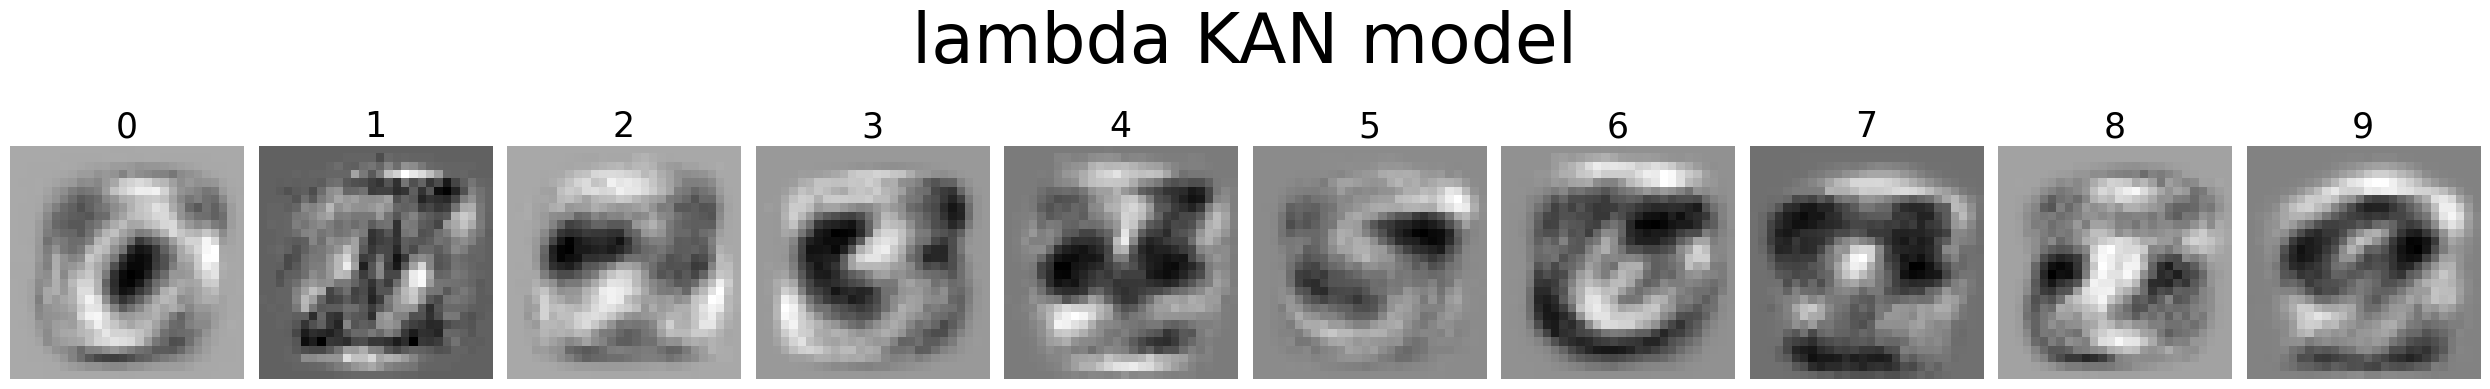

In [38]:
lmd_W = []
for i in range(10):
    lmd_W.append(pl_model.model.l_layers[i][1].lmd.detach().clone().numpy())

lmd_W = np.array(lmd_W).transpose(1,0)
show_sensitivity(lmd_W, title='lambda KAN model')

## trainable lambda KAN

### Calculate metrics on test dataset

In [39]:
log_path='logs/Mnist_tlmdSplineKAN/lightning_logs/version_0/'
ckpt_path = f"{log_path}/checkpoints/last.ckpt"

pl_model = LModel.load_from_checkpoint(ckpt_path)
# Load the best checkpoint automatically (lightning tracks this for you)
lmdKAN_acc = trainer.test(
    model=pl_model, dataloaders=test_loader, verbose=True)[0]['MulticlassAccuracy']
pl_model

Testing DataLoader 0: 100%|██████████| 40/40 [00:23<00:00,  1.73it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│    MulticlassAccuracy     │    0.9504374265670776     │
└───────────────────────────┴───────────────────────────┘

LModel(
  (model): Mnist_tlmdSplineKAN(
    (l_layers): ModuleList(
      (0-9): 10 x Sequential(
        (0): Flatten(start_dim=1, end_dim=-1)
        (1): tlmdSplineKANLayer(
          (base_fun): SiLU()
          (tlmd_model): MLP(
            (linears): ModuleList(
              (0): Linear(in_features=784, out_features=64, bias=True)
              (1): Linear(in_features=64, out_features=784, bias=True)
            )
            (act_fun): SiLU()
          )
        )
        (2): Tanh()
        (3): Linear(in_features=16, out_features=8, bias=True)
        (4): Tanh()
        (5): Linear(in_features=8, out_features=1, bias=True)
      )
    )
  )
  (criterion): CrossEntropyLoss()
  (metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy()
  )
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    postfix=/train
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    postfix=/val
  )
)

### Plot sensitivity map

Shape with bias: (784, 10)


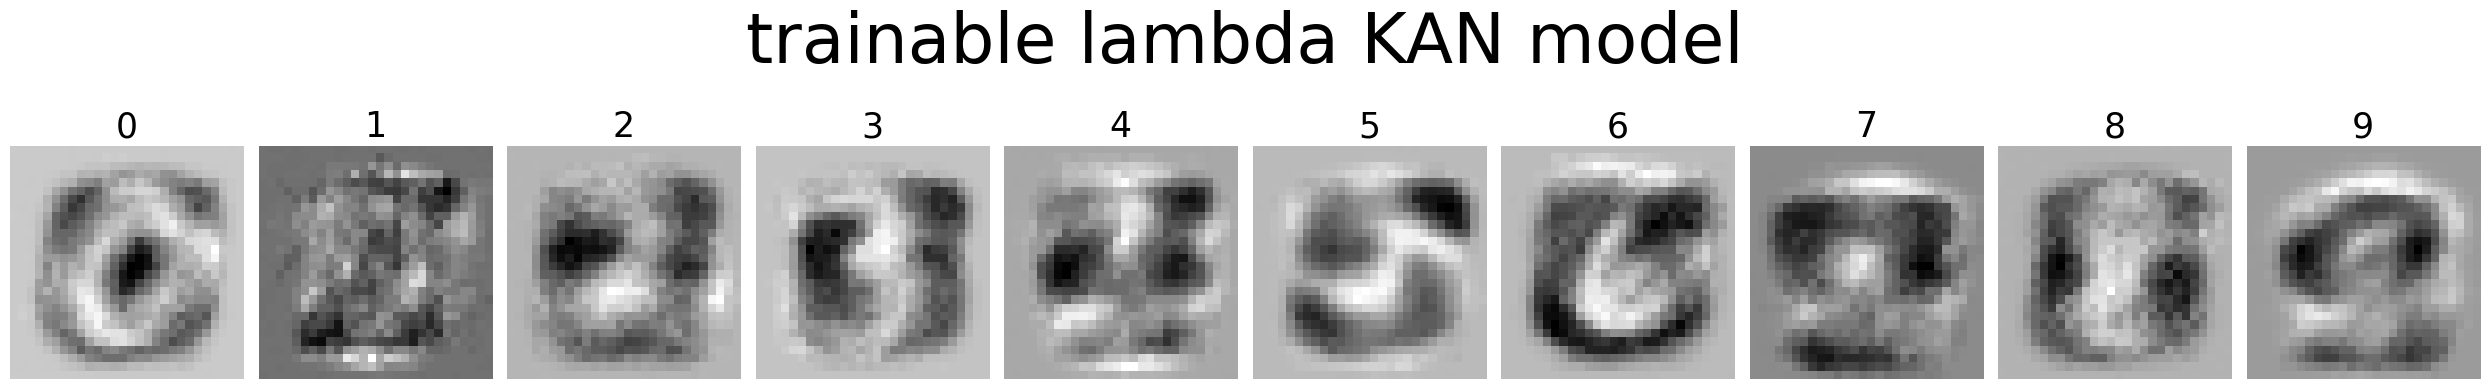

In [41]:
lmd_W = []
for i in range(10):
    lmd_W.append(pl_model.model.l_layers[i][1].lmd.detach().clone().numpy())

lmd_W = np.array(lmd_W).transpose(1,0)
show_sensitivity(lmd_W, title='trainable lambda KAN model')